<a href="https://colab.research.google.com/github/BondaiKa/lane_line_recognition/blob/feature%2Ftu-simple-using/notebooks/VIL100_shorte_standardize_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import os
import numpy as np
import glob
import json
import math
import cv2
import h5py
import logging
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf

from abc import ABCMeta, abstractmethod
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, Model
from typing import Tuple, List, Dict, Iterable, Optional, NamedTuple, Union, Tuple, List, Callable, Type
from pathlib import Path
from google.colab.patches import cv2_imshow

%matplotlib inline

In [17]:
log = logging.getLogger(__name__)

In [18]:
!ls drive/MyDrive/Ilmenau/tusimple/

label_data_joined.json	test_set.zip			  train_set.zip
test_label.json		train_label_data_joined_old.json


In [19]:
%%capture
!unrar x -Y "/content/drive/My Drive/Ilmenau/dataset.rar" "/tmp/"

In [20]:
INPUT_SHAPE = (256, 256, 1)
FINAL_WIDTH=INPUT_SHAPE[0]
FINAL_HEIGHT=INPUT_SHAPE[1]
FINAL_SHAPE = (INPUT_SHAPE[0],INPUT_SHAPE[1])
BATCH_SIZE = 32
AMOUNT_OF_FRAMES = 10000
VALIDATION_SPLIT = 0.1
MAX_LINES_PER_FRAME = 2
MAX_NUM_POINTS =  31
NUM_TYPE_OF_LINES = 5

MODEL_NAME = f'standart-output-polyline-{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}-shape'

In [21]:
BASE_DIR = "/tmp/dataset/VIL100/"
IMAGE_PATH = BASE_DIR + "JPEGImages/"
JSON_PATH = BASE_DIR + "Json/"
JSON_HDF5_DATASET_PATH = BASE_DIR + "hdf5/"


print(IMAGE_PATH)
print(JSON_PATH)
print(JSON_HDF5_DATASET_PATH)

/tmp/dataset/VIL100/JPEGImages/
/tmp/dataset/VIL100/Json/
/tmp/dataset/VIL100/hdf5/


In [22]:
initial_frame_glob_path = IMAGE_PATH+'*/*.jpg'
json_glob_path = JSON_PATH + '*/*.json'

images = glob.glob(initial_frame_glob_path)
json_files = glob.glob(json_glob_path)

In [23]:
print(initial_frame_glob_path)
print(json_glob_path)

print(len(images))
print(len(json_files))

/tmp/dataset/VIL100/JPEGImages/*/*.jpg
/tmp/dataset/VIL100/Json/*/*.json
10000
10000


In [24]:
class Color(NamedTuple):
    red = (255, 0, 0)
    green = (0, 255, 0)
    blue = (0, 0, 255)
    purple = (255, 0, 255)
    yellow = (255, 255, 0)

    sequence = [red, green, blue, purple, yellow]

LANE_ID_FULL_LIST = set(range(1, 10))

class Vil100Json:
    ANNOTATIONS = 'annotations'
    # Annotations
    ATTRIBUTE = 'attribute'
    LANE = 'lane'
    LANE_ID = 'lane_id'
    POINTS = 'points'

    INFO = 'info'
    # Info
    IMAGE_PATH = 'image_path'
    HEIGHT = 'height'
    WIDTH = 'width'


class VIL100Attribute:
    """Lane Attribute id (type lane) in jsons"""
    SINGLE_WHITE_SOLID = 1
    SINGLE_WHITE_DOTTED = 2
    SINGLE_YELLOW_SOLID = 3
    SINGLE_YELLOW_DOTTED = 4
    DOUBLE_WHITE_SOLID = 5
    DOUBLE_YELLOW_SOLID = 7
    DOUBLE_YELLOW_DOTTED = 8
    DOUBLE_WHITE_SOLID_DOTTED = 9
    DOUBLE_WHITE_DOTTED_SOLID = 10
    DOUBLE_SOLID_WHITE_AND_YELLOW = 13


class LineType:
    """Type lane in our task"""
    NO_LINE = 0
    SINGLE_WHITE_SOLID = 1
    SINGLE_WHITE_DOTTED = 2
    OTHER_LINE = 3

    ALL_LINES = {NO_LINE, SINGLE_WHITE_SOLID, SINGLE_WHITE_DOTTED, OTHER_LINE}


VIL_100_colour_line = {
    LineType.SINGLE_WHITE_SOLID: (255, 0, 0),
    LineType.SINGLE_WHITE_DOTTED: (0, 255, 0),
    LineType.OTHER_LINE: (0, 0, 255),
    # 4: (255, 255, 0),  # single yellow dotted
    # 5: (255, 0, 0),  # double white solid
    # 6: (255, 125, 0),  # double yellow solid
    # 7: (255, 255, 0),  # double yellow dotted
    # 8: (255, 0, 0),  # double white solid dotted
    # 9: (255, 0, 0),  # double white dotted solid
    # 10: (255, 0, 0),  # double solid white and yellow
}


class VIL100HDF5:
    ROOT_FOLDER = 'hdf5'
    GROUP_NAME = 'frame_polylines_labels'
    POLYLINE_WIDTHS_DATASET_NAME = 'polyline_widths'
    POLYLINE_HEIGHTS_DATASET_NAME = 'polyline_heights'
    LABELS_DATASET_NAME = 'labels'


def get_valid_attribute(attr: int) -> int:
    """Change attribute from VIL100_dataset dataset to normal number without missings"""
    _VIL_100_attributes = {
        LineType.NO_LINE: LineType.NO_LINE,
        VIL100Attribute.SINGLE_WHITE_SOLID: LineType.SINGLE_WHITE_SOLID,
        VIL100Attribute.SINGLE_WHITE_DOTTED: LineType.SINGLE_WHITE_DOTTED,
        VIL100Attribute.SINGLE_YELLOW_SOLID: LineType.SINGLE_WHITE_SOLID,
        VIL100Attribute.SINGLE_YELLOW_DOTTED: LineType.SINGLE_WHITE_DOTTED,
        VIL100Attribute.DOUBLE_WHITE_SOLID: LineType.OTHER_LINE,
        VIL100Attribute.DOUBLE_YELLOW_SOLID: LineType.OTHER_LINE,
        VIL100Attribute.DOUBLE_YELLOW_DOTTED: LineType.OTHER_LINE,
        VIL100Attribute.DOUBLE_WHITE_SOLID_DOTTED: LineType.OTHER_LINE,
        VIL100Attribute.DOUBLE_WHITE_DOTTED_SOLID: LineType.OTHER_LINE,
        VIL100Attribute.DOUBLE_SOLID_WHITE_AND_YELLOW: LineType.OTHER_LINE,
    }
    return _VIL_100_attributes.get(attr, LineType.NO_LINE)

def get_colour_from_one_hot_vector(vector: np.ndarray) -> Tuple[int, int, int]:
    """Get colour from one hot vector"""
    return VIL_100_colour_line.get(int(np.argmax(vector, axis=1)), None)


def one_hot_list_encoder(target_class_idx: int, num_classes: int) -> np.ndarray:
    """One-hot list encoder"""
    target_vector = np.zeros(num_classes)
    target_vector[target_class_idx] = 1
    return target_vector

In [25]:
from abc import ABCMeta, abstractmethod


class AbstractConverter(metaclass=ABCMeta):
    @abstractmethod
    def get_data_from_file(self, json_path: str):
        raise NotImplementedError

    @abstractmethod
    def exec(self):
        raise NotImplementedError


In [26]:
class JsonReviewer:
    def __init__(self, json_glob_path: str, frame_dataset_path: str):
        self.json_glob_path = sorted(glob.glob(json_glob_path))
        self.frame_dataset_path = frame_dataset_path

    @staticmethod
    def fix_json_file(json_file: Dict[str, Union[str, int]], frame_real_height: int, frame_real_width: int,
                      frame_path: str) -> Dict[str, Union[str, int]]:
        if json_file[Vil100Json.INFO][Vil100Json.HEIGHT] != frame_real_height or \
                json_file[Vil100Json.INFO][Vil100Json.WIDTH] != frame_real_width:
            log.debug(f'Different resolution! File name: `{frame_path}`.')
            json_file[Vil100Json.INFO][Vil100Json.HEIGHT] = frame_real_height
            json_file[Vil100Json.INFO][Vil100Json.WIDTH] = frame_real_width

        return json_file

    def exec(self):
        for json_file_path in self.json_glob_path:
            # TODO: check open format
            with open(json_file_path, 'r+') as f:
                json_file = json.load(f)
                image_path = json_file[Vil100Json.INFO][Vil100Json.IMAGE_PATH]
                full_path = self.frame_dataset_path + '/' + image_path
                frame = cv2.imread(full_path)
                height, width = frame.shape[0], frame.shape[1]

                json_file = self.fix_json_file(json_file, height, width, image_path)

                f.seek(0)
                json.dump(json_file, f)
                f.truncate()

In [27]:
polyline_width_type = np.ndarray
polyline_height_type = np.ndarray
labels_type = np.ndarray
class VIL100JsonConverter(AbstractConverter):
    def __init__(self,
                 max_lines_per_frame: int,
                 max_num_points: int,
                 num_type_of_lines: int,
                 json_glob_path: str,
                 final_shape: Tuple[int, int],
                 frame_dataset_path: str,
                 ):

        self.max_lines_per_frame = max_lines_per_frame
        self.max_num_points = max_num_points
        self.num_type_of_lines = num_type_of_lines
        self.json_files = sorted(glob.glob(json_glob_path))
        self.files_count = len(self.json_files)
        self.frame_dataset_path = frame_dataset_path
        self.final_shape = final_shape

        message = f"VILJsonConverter params:\n {locals()}"
        log.debug(message)
        print(message)

    @staticmethod
    def __rescale_coordinates(row: np.ndarray, initial_width: int, initial_height: int) -> np.ndarray:
        return row[0] / initial_width, row[1] / initial_height

    def __rescale_polylines(self, polylines: np.ndarray, initial_width: int, initial_height: int) -> np.ndarray:
        """Rescale coordinates due to new frame resolution"""
        return np.apply_along_axis(self.__rescale_coordinates, axis=1, arr=polylines,
                                   initial_width=initial_width,
                                   initial_height=initial_height
                                   )

    def __get_polyline_with_label(self, lane: dict, initial_width: int, initial_height: int) \
            -> Tuple[Tuple[polyline_width_type, polyline_height_type], labels_type]:
        """Get array from points list"""
        points = np.array(
            lane[Vil100Json.POINTS])  # todo: fix
        # widths, height = np.split(points, 2, axis=1)
        points = self.__rescale_polylines(points, initial_width=initial_width, initial_height=initial_height).flatten()
        points = np.pad(points, pad_width=(self.max_num_points * 3 * 2 - points.shape[0], 0),
                        mode='constant', constant_values=(-1,))
        points = tuple(np.split(points.reshape(-1, 2), 2, axis=1))
        polyline_widths, polyline_heights = points[0].flatten(), points[1].flatten()
        # TODO @Karim: remember below `label.get(label)` is index 1,2,3,4
        polyline_widths = polyline_widths[0::3]
        polyline_heights = polyline_heights[0::3]
        label = get_valid_attribute(lane.get(Vil100Json.ATTRIBUTE, LineType.NO_LINE))
        labels = one_hot_list_encoder(label, self.num_type_of_lines)
        return (polyline_widths, polyline_heights), labels

    @staticmethod
    def _get_frame_shape(frame_path: np.ndarray) -> Tuple[int, int]:
        """Check that each frame has same expected shape"""
        frame = cv2.imread(frame_path)
        height, width = frame.shape[0], frame.shape[1]
        return width, height

    def get_data_from_file(self, json_path: str) -> Tuple[Tuple[polyline_width_type, polyline_height_type], np.ndarray]:
        """
        Retrieve from json file polylines and labels and format to nn input

        :param json_path: json file path
        :return: frame and tuple of labels
        """
        with open(json_path) as f:
            json_file: Dict[str, Union[int, dict]] = json.load(f)

        image_path = json_file[Vil100Json.INFO][Vil100Json.IMAGE_PATH]
        full_frame_path = self.frame_dataset_path + '/' + image_path
        width, height = self._get_frame_shape(frame_path=full_frame_path)

        json_file = JsonReviewer.fix_json_file(
            json_file=json_file,
            frame_real_height=height,
            frame_real_width=width,
            frame_path=image_path,
        )

        lanes: Lane_type = json_file[Vil100Json.ANNOTATIONS][Vil100Json.LANE]
        lanes = sorted(lanes, key=lambda lane: lane[Vil100Json.LANE_ID])

        polyline_widths_output = np.empty(shape=(0, self.max_num_points)),
        polyline_heights_output = np.empty(shape=(0, self.max_num_points))
        labels_output = np.empty(shape=(0, self.num_type_of_lines))

        exist_lane = [x[Vil100Json.LANE_ID] for x in lanes]
        missed_lane = LANE_ID_FULL_LIST - set(exist_lane)

        for lane_id in range(1, self.max_lines_per_frame + 1):
            if lane_id in missed_lane:
                points: Tuple[polyline_width_type, polyline_height_type] = (
                    np.full(shape=self.max_num_points, fill_value=-1),
                    np.full(shape=self.max_num_points, fill_value=-1)
                )
                label = one_hot_list_encoder(LineType.NO_LINE, self.num_type_of_lines)
            else:
                points, label = self.__get_polyline_with_label(
                    lane=lanes[exist_lane.index(lane_id)],
                    initial_width=width,
                    initial_height=height
                )
            polyline_widths, polyline_heights = points[0], points[1]
            polyline_widths_output = np.append(polyline_widths_output, polyline_widths)
            polyline_heights_output = np.append(polyline_heights_output, polyline_heights)
            labels_output = np.append(labels_output, label)

        return (polyline_widths_output, polyline_heights_output), labels_output

    def exec(self) -> None:
        """Convert and save json files to new hdf5 files"""
        for json_file_path in self.json_files:
            polylines, labels = self.get_data_from_file(json_file_path)
            polyline_widths, polyline_heights = polylines[0], polylines[1]
            full_path_list = json_file_path.split('/')
            full_path_list[-3] = VIL100HDF5.ROOT_FOLDER
            root_path = full_path_list[:-1]
            frame_name = full_path_list[-1]

            Path(f"{'/'.join(root_path)}").mkdir(parents=True, exist_ok=True)

            with h5py.File(f"{'/'.join(root_path)}/{frame_name}.hdf5", "w") as f:
                grp = f.create_group(VIL100HDF5.GROUP_NAME)
                grp.create_dataset(VIL100HDF5.POLYLINE_WIDTHS_DATASET_NAME, data=polyline_widths, dtype='float32')
                grp.create_dataset(VIL100HDF5.POLYLINE_HEIGHTS_DATASET_NAME, data=polyline_heights, dtype='float32')
                grp.create_dataset(VIL100HDF5.LABELS_DATASET_NAME, data=labels, dtype='float32')

In [28]:
vil_100_converter = VIL100JsonConverter(
        max_lines_per_frame=MAX_LINES_PER_FRAME,
        max_num_points=MAX_NUM_POINTS,
        num_type_of_lines=NUM_TYPE_OF_LINES,
        json_glob_path=json_glob_path,
        final_shape=(INPUT_SHAPE[0],INPUT_SHAPE[1]),
        frame_dataset_path=IMAGE_PATH,
)

VILJsonConverter params:
 {'self': <__main__.VIL100JsonConverter object at 0x7efd616484d0>, 'max_lines_per_frame': 2, 'max_num_points': 31, 'num_type_of_lines': 5, 'json_glob_path': '/tmp/dataset/VIL100/Json/*/*.json', 'final_shape': (256, 256), 'frame_dataset_path': '/tmp/dataset/VIL100/JPEGImages/'}


In [ ]:
vil_100_converter.exec()

In [30]:
class AbstractFrameGenerator(metaclass=ABCMeta):
    @abstractmethod
    def get_data_from_file(self, *args, **kwargs):
        raise NotImplementedError

    def get_frame_from_file(self, frame_path: str) -> np.ndarray:
        frame = tf.keras.utils.load_img(frame_path,
                                        color_mode=self.color_mode,
                                        target_size=(self.final_shape[1], self.final_shape[0])
                                        )
        frame = tf.keras.preprocessing.image.img_to_array(frame)
        frame = frame * self.rescale
        frame = np.expand_dims(frame, 0)
        return frame


class AbstractFrameGeneratorCreator(metaclass=ABCMeta):
    TRAINING = 'training'
    VALIDATION = 'validation'

    __reverse_dataset_type = {
        TRAINING: VALIDATION,
        VALIDATION: TRAINING
    }
    __dataset = {}

    def __init__(self,
                 validation_split: float,
                 frame_glob_path: str,
                 json_hdf5_glob_path: str):
        """
        :param validation_split: split for train/validation sets
        :param frame_glob_path: glob pattern of frames
        :param json_hdf5_glob_path: glob pattern path of jsons
        """
        self.validation_split = validation_split
        self.__frame_glob_path = frame_glob_path
        self.__json_hdf5_glob_path = json_hdf5_glob_path

    def preprocess_files(self, subset: str, number_files: int) -> Tuple[List[str], List[str]]:
        """
        Sort and validate files for further loading and sending to NN

        :param subset: 'training' or 'validation'
        :param number_files: restrict max number of files from dataset
        :return: list of sorted and sliced files and json files
        """

        files = sorted(glob.glob(self.__frame_glob_path))
        log.info(f"Number of files in dataset: {len(files)}. Using in training/validation: {number_files}")
        files = files[:number_files]

        json_files = sorted(glob.glob(self.__json_hdf5_glob_path))[:number_files]
        files_count = len(files)
        json_files_count = len(json_files)

        if files_count != json_files_count:
            log.error(f"Dataset files error"
                      f"Number of frames: ({files_count}). "
                      f"Number of jsons({json_files_count}")
            raise FileNotFoundError(
                f"Numbers of frames and jsons are not equal!")

        if not self.__reverse_dataset_type.get(subset):
            log.error(f'Wrong subset value: "{subset}"')
            raise ValueError(f'Wrong type of subset - {subset}. '
                             f'Available types: {self.__reverse_dataset_type.keys()}')

        if self.validation_split and 0.0 < self.validation_split < 1.0:
            split = int(files_count * (1 - self.validation_split))
            if subset == self.TRAINING:
                files = files[:split]
                json_files = json_files[:split]
            else:
                files = files[split:]
                json_files = json_files[split:]

        return files, json_files

    @abstractmethod
    def get_generator(self) -> Type:
        raise NotImplementedError

    def flow_from_directory(self,
                            subset: str,
                            number_files: int,
                            *args, **kwargs) -> Callable:
        files, json_files = self.preprocess_files(subset=subset,
                                                  number_files=number_files)
        return self.get_generator()(files=files,
                                    json_files=json_files,
                                    *args, **kwargs)


In [31]:
class VIL100FrameGenerator(AbstractFrameGenerator, Sequence):
    """Sequence of frames generator

    Usage for training NN that could process independent
    frames without context window etc
    """

    def __init__(self,
                 num_type_of_lines,

                 max_lines_per_frame,
                 max_num_points,
                 batch_size: int,
                 final_shape: Tuple[int, int],
                 shuffle: bool,
                 files: Optional[List[str]],
                 json_files: Optional[List[str]],
                 rescale=1 / 255.,
                 color_mode: str = 'grayscale',
                 ):
        """
        :param max_lines_per_frame: maximum number of lines per frame
        :param max_num_points: maximum number of points un one polyline
        :param num_type_of_lines: number of possible lines on road
        :param rescale:
        :param batch_size: batch size of the dataset
        :param final_shape: final size for NN input
        :param shuffle: shuffle flag of frames sequences
        :param color_mode: `grayscale` or `rgb` color reading frame mod
        :param json_files: list of json files that contain info about a frame
        """
        self.max_lines_per_frame = max_lines_per_frame
        self.max_num_points = max_num_points
        self.num_type_of_lines = num_type_of_lines
        self.rescale = rescale
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.final_shape = final_shape
        self.color_mode = color_mode
        self.files = files
        self.json_files = json_files
        self.files_count = len(self.files)

        if shuffle:
            temp = list(zip(self.files, self.json_files))
            random.shuffle(temp)
            self.files, self.json_files = zip(*temp)

        message = f"VIL100 Frame Generator params:\n {locals()}"
        log.debug(message)
        print(message)

    def __len__(self):
        return math.ceil(self.files_count / self.batch_size)

    def get_data_from_file(self, json_path: str) -> Tuple[Tuple[np.ndarray, np.ndarray], np.ndarray]:
        """
        Get from hdf5 all polylines and their labels
        :param json_path: path of json file
        :return: polylines with labels
        """
        file = h5py.File(json_path, 'r')
        group = file.get(VIL100HDF5.GROUP_NAME)
        return (group.get(VIL100HDF5.POLYLINE_WIDTHS_DATASET_NAME),
                group.get(VIL100HDF5.POLYLINE_HEIGHTS_DATASET_NAME)
                ), group.get(VIL100HDF5.LABELS_DATASET_NAME)

    def __getitem__(self, idx) -> Tuple[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
        batch_frames_path = self.files[idx * self.batch_size:
                                       (idx + 1) * self.batch_size]
        batch_json_path = self.json_files[idx * self.batch_size:
                                          (idx + 1) * self.batch_size]

        polyline_width_output = np.empty(shape=(0, self.max_lines_per_frame * self.max_num_points))
        polyline_height_output = np.empty(shape=(0, self.max_lines_per_frame * self.max_num_points))
        labels_output = np.empty(shape=(0, self.num_type_of_lines * self.max_lines_per_frame))
        frame_output = np.empty(shape=(0, self.final_shape[0], self.final_shape[1],1))

        for _frame, _json in zip(batch_frames_path, batch_json_path):
            polylines, labels = self.get_data_from_file(_json)
            polyline_widths, polyline_heights = polylines[0], polylines[1]

            polyline_width_output = np.vstack((polyline_width_output, polyline_widths))
            polyline_height_output = np.vstack((polyline_height_output, polyline_heights))
            labels_output = np.vstack((labels_output, labels))
            frame = self.get_frame_from_file(_frame)
            frame_output = np.vstack((frame_output, frame))

        return frame_output, (polyline_width_output, polyline_height_output)


class VIL100FrameGeneratorCreator(AbstractFrameGeneratorCreator):

    def get_generator(self) -> Type[VIL100FrameGenerator]:
        return VIL100FrameGenerator

In [32]:
data_gen = VIL100FrameGeneratorCreator(
    validation_split=VALIDATION_SPLIT, 
    frame_glob_path=initial_frame_glob_path, 
    json_hdf5_glob_path=JSON_HDF5_DATASET_PATH+'/*/*.hdf5',
)

train_generator = data_gen.flow_from_directory(
  subset='training', shuffle=False, batch_size = BATCH_SIZE, 
  number_files=AMOUNT_OF_FRAMES, max_lines_per_frame=MAX_LINES_PER_FRAME,
  max_num_points = MAX_NUM_POINTS, num_type_of_lines = NUM_TYPE_OF_LINES,
  final_shape=INPUT_SHAPE,
)

validation_generator = data_gen.flow_from_directory(
  subset='validation', shuffle=False, batch_size = BATCH_SIZE, 
  number_files=AMOUNT_OF_FRAMES, max_lines_per_frame=MAX_LINES_PER_FRAME,
  max_num_points = MAX_NUM_POINTS, num_type_of_lines = NUM_TYPE_OF_LINES,
  final_shape=INPUT_SHAPE,
)


VIL100 Frame Generator params:
 {'self': <__main__.VIL100FrameGenerator object at 0x7efd628aac10>, 'num_type_of_lines': 5, 'max_lines_per_frame': 2, 'max_num_points': 31, 'batch_size': 32, 'final_shape': (256, 256, 1), 'shuffle': False, 'files': ['/tmp/dataset/VIL100/JPEGImages/0_Road001_Trim003_frames/00000.jpg', '/tmp/dataset/VIL100/JPEGImages/0_Road001_Trim003_frames/00003.jpg', '/tmp/dataset/VIL100/JPEGImages/0_Road001_Trim003_frames/00006.jpg', '/tmp/dataset/VIL100/JPEGImages/0_Road001_Trim003_frames/00009.jpg', '/tmp/dataset/VIL100/JPEGImages/0_Road001_Trim003_frames/00012.jpg', '/tmp/dataset/VIL100/JPEGImages/0_Road001_Trim003_frames/00015.jpg', '/tmp/dataset/VIL100/JPEGImages/0_Road001_Trim003_frames/00018.jpg', '/tmp/dataset/VIL100/JPEGImages/0_Road001_Trim003_frames/00021.jpg', '/tmp/dataset/VIL100/JPEGImages/0_Road001_Trim003_frames/00024.jpg', '/tmp/dataset/VIL100/JPEGImages/0_Road001_Trim003_frames/00027.jpg', '/tmp/dataset/VIL100/JPEGImages/0_Road001_Trim003_frames/00030.

In [33]:
def concat_polyline(polyline_width: np.ndarray, polyline_height: np.ndarray) -> np.ndarray:
    return np.concatenate((polyline_width.reshape(-1, 1), polyline_height.reshape(-1, 1)), axis=1)


def test_vil_100_simple_generator(generator: Sequence, draw_line=False) -> None:
    """Test tu simple generator"""
    original_frames, original_polylines = generator[0]

    original_frame = original_frames[0] * 255
    polyline_widths, polyline_height = original_polylines[0][0], original_polylines[1][0]

    polyline_width_list = np.split(polyline_widths, MAX_LINES_PER_FRAME)
    polyline_height_list = np.split(polyline_height, MAX_LINES_PER_FRAME)


    if draw_line:
        for polyline_width, polyline_height in zip(polyline_width_list, polyline_height_list):
            polyline_width *= INPUT_SHAPE[0]
            polyline_height *= INPUT_SHAPE[1]
            polyline = concat_polyline(polyline_width, polyline_height)
            original_frame = cv2.polylines(original_frame, np.int32(polyline).reshape((-1, 1, 2)), 1,
                                           color=(255,0,0),
                                           thickness=5)

    cv2_imshow(original_frame)
    cv2.waitKey(0)

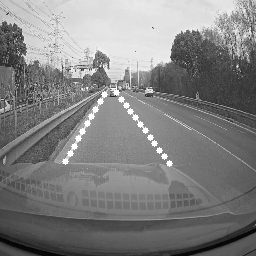

In [34]:
test_vil_100_simple_generator(train_generator, draw_line=True)

In [35]:
def build_model(polyline_width_output_shape:int ,polyline_height_output_shape:int, input_shape:Tuple[int,int,int], model_name:str):

    input_img = layers.Input(shape=input_shape)

    # First block
    layer = layers.Conv2D(256, (3, 3), activation='relu',use_bias=False)(input_img)
    layer = layers.BatchNormalization()(layer)
    layer = layers.MaxPooling2D()(layer)

    # Second block
    layer = layers.Conv2D(256, (3, 3), activation='relu',use_bias=False)(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.MaxPooling2D()(layer)

    # Third block
    layer = layers.Conv2D(128, (3, 3), activation='relu',use_bias=False)(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.MaxPooling2D()(layer)

    # Fourth block
    layer = layers.Conv2D(64, (3, 3), activation='relu',use_bias=False)(layer)
    layer = layers.BatchNormalization()(layer)

    # GlobalMaxPool
    layer = layers.GlobalMaxPool2D()(layer)

    # polyline common part 
    polyline_common = tf.keras.layers.Dense(units=512, activation='relu')(layer)
    polyline_common = layers.BatchNormalization()(polyline_common)
    polyline_common = layers.Dropout(.2)(polyline_common) 

    # polyline height
    pol_1 = tf.keras.layers.Dense(units=256, activation='relu')(polyline_common)
    pol_1 = layers.BatchNormalization()(pol_1)
    pol_1 = layers.Dropout(.2)(pol_1)

    pol_1 = tf.keras.layers.Dense(units=128,activation='relu')(pol_1)
    pol_1 = layers.BatchNormalization()(pol_1)
    pol_1 = layers.Dropout(.2)(pol_1)

    # polyline width 
    pol_2 = tf.keras.layers.Dense(units=256, activation='relu')(polyline_common)
    pol_2 = layers.BatchNormalization()(pol_2)
    pol_2 = layers.Dropout(.2)(pol_2)

    pol_2 = tf.keras.layers.Dense(units=128,activation='relu')(pol_2)
    pol_2 = layers.BatchNormalization()(pol_2)
    pol_2 = layers.Dropout(.2)(pol_2)

    # output
    polyline_output_width = layers.Dense(polyline_width_output_shape,name='polyline_width')(pol_1)
    polyline_output_height = layers.Dense(polyline_height_output_shape,name='polyline_height')(pol_2)

    model = Model(input_img, outputs=[
        polyline_output_width,
        polyline_output_height,
      ], name = model_name
    )

    return model

In [36]:
model_name = MODEL_NAME
logdir = f"logs/{model_name}"
checkpoint_filepath = f"/model/{model_name}"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stop_polyline_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_polyline_width_loss'
)

reduce_lr_callback_depends_on_polyline_1_loss = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_polyline_width_loss', factor=0.8, patience=2, verbose=1, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0.00001
)
reduce_lr_callback_depends_on_polyline_2_loss = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_polyline_height_loss', factor=0.8, patience=2, verbose=1, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0.00001
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_polyline_width_loss',
    mode='max',
    save_best_only=True)

In [37]:
class DrawPolylineOnEpochEnd(tf.keras.callbacks.Callback):
  """Draw polyline at the end on the epoch to test the net. It skip one batch on validation but похуй"""
  def __init__(self,train_generator, validation_generator,model,*args,**kwargs):
    super().__init__(*args,**kwargs)
    self.train_generator = train_generator
    self.validation_generator = validation_generator
    self.model = model

  def __filter_coordination_for_resolution(self, polyline: np.ndarray) -> np.ndarray:
    valid = ((polyline[:, 0] > 0) & (polyline[:, 1] > 0)
              & (polyline[:, 0] < INPUT_SHAPE[0]) & (polyline[:, 1] < INPUT_SHAPE[1]))
    return polyline[valid]

  def __filter_coordinates(self, list_of_polylines: List[np.ndarray]) -> np.ndarray:
    """Remove empty points and coordinates x or y, that is less than 0"""
    list_of_polylines = list(map(lambda x: x.reshape(-1, 2), list_of_polylines))
    return list(map(lambda polyline: self.__filter_coordination_for_resolution(polyline),
                    list_of_polylines))  

  def concat_polyline(self,polyline_width: np.ndarray, polyline_height: np.ndarray) -> np.ndarray: 
    return np.concatenate((polyline_width.reshape(-1, 1), polyline_height.reshape(-1, 1)), axis=1)

  def draw_polyline_in_frame(self, _frame:np.ndarray, polylines:Tuple[np.ndarray,np.ndarray],thickness:int)->np.ndarray:
    copy_frame = np.copy(_frame)
    polyline_widths, polyline_heights = polylines[0][0], polylines[1][0]
    polyline_width_list = np.split(polyline_widths, MAX_LINES_PER_FRAME)
    polyline_height_list = np.split(polyline_heights, MAX_LINES_PER_FRAME)

    for polyline_width, polyline_height in zip(polyline_width_list, polyline_height_list):
      polyline_width *= INPUT_SHAPE[0]
      polyline_height *= INPUT_SHAPE[1]
      polyline = self.concat_polyline(polyline_width, polyline_height)
      polyline = self.__filter_coordination_for_resolution(polyline)
      copy_frame = cv2.polylines(copy_frame, np.int32(polyline).reshape((-1, 1, 2)), 1,
                                      color=(255,0,0),
                                      thickness=thickness)
    return copy_frame

  def test_model(self, generator: Sequence):
    original_frames, original_polylines = generator[0]
    original_frame = original_frames[0]

    draw_original_polylines_frame = self.draw_polyline_in_frame(original_frame,original_polylines,thickness=2)

    original_frame = np.copy(original_frame)
    frame = np.expand_dims(original_frame, 0)
    res = self.model.predict(frame)

    final_frame = self.draw_polyline_in_frame(draw_original_polylines_frame,res,thickness=4)
    cv2_imshow(final_frame * 255)

  def on_epoch_end(self, epoch, logs=None):
      print(f'Epoch {epoch}. Draw polylines on train generator...')
      self.test_model(self.train_generator)



In [38]:
model = build_model(
    polyline_width_output_shape = MAX_NUM_POINTS * MAX_LINES_PER_FRAME, 
    polyline_height_output_shape = MAX_NUM_POINTS * MAX_LINES_PER_FRAME, 
    input_shape = INPUT_SHAPE,
    model_name = MODEL_NAME,
)
# print(model.summary())

In [39]:
# tf.experimental.numpy.experimental_enable_numpy_behavior()
# tf.keras.utils.plot_model(model, "multi_output_model.png", show_shapes=True)

In [40]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.01

model.compile(loss= {
      'polyline_width':tf.keras.losses.MeanAbsoluteError(),
      'polyline_height':tf.keras.losses.MeanAbsoluteError(),
    },
    optimizer=Adam(learning_rate=learning_rate),
    metrics={'polyline_width':tf.keras.metrics.MeanSquaredError(),
             'polyline_height':tf.keras.metrics.MeanSquaredError(),
             },)

In [41]:
# polyline_model_path = '/standart-output-polyline-256x256-shape.h5'
# model = tf.keras.models.load_model(polyline_model_path)

Epoch 1/3
Epoch 0. Draw polylines on train generator...


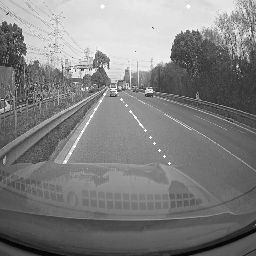

282/282 - 335s - loss: 0.5105 - polyline_width_loss: 0.2417 - polyline_height_loss: 0.2688 - polyline_width_mean_squared_error: 0.2317 - polyline_height_mean_squared_error: 0.2678 - val_loss: 1.4514 - val_polyline_width_loss: 0.6885 - val_polyline_height_loss: 0.7629 - val_polyline_width_mean_squared_error: 1.6737 - val_polyline_height_mean_squared_error: 1.4603 - lr: 0.0100 - 335s/epoch - 1s/step
Epoch 2/3
Epoch 1. Draw polylines on train generator...


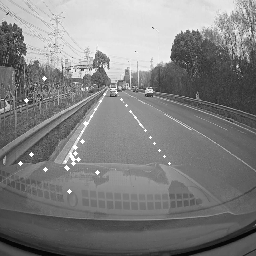

282/282 - 318s - loss: 0.2862 - polyline_width_loss: 0.1294 - polyline_height_loss: 0.1568 - polyline_width_mean_squared_error: 0.1293 - polyline_height_mean_squared_error: 0.1594 - val_loss: 0.5504 - val_polyline_width_loss: 0.3289 - val_polyline_height_loss: 0.2215 - val_polyline_width_mean_squared_error: 0.3483 - val_polyline_height_mean_squared_error: 0.2738 - lr: 0.0100 - 318s/epoch - 1s/step
Epoch 3/3
Epoch 2. Draw polylines on train generator...


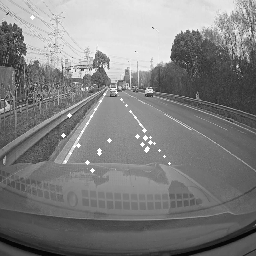

282/282 - 311s - loss: 0.2685 - polyline_width_loss: 0.1208 - polyline_height_loss: 0.1477 - polyline_width_mean_squared_error: 0.1273 - polyline_height_mean_squared_error: 0.1588 - val_loss: 0.4225 - val_polyline_width_loss: 0.2000 - val_polyline_height_loss: 0.2225 - val_polyline_width_mean_squared_error: 0.2637 - val_polyline_height_mean_squared_error: 0.2631 - lr: 0.0100 - 311s/epoch - 1s/step


In [42]:
history = model.fit(train_generator,
                    epochs=3,
                    verbose=2,
                    validation_data=validation_generator,
                    callbacks=[
                        tensorboard_callback,
                        early_stop_polyline_callback,
                        reduce_lr_callback_depends_on_polyline_1_loss,
                        reduce_lr_callback_depends_on_polyline_2_loss,
                        model_checkpoint_callback,
                        DrawPolylineOnEpochEnd(train_generator=train_generator, validation_generator=validation_generator,model=model)
                      ],
                    )

In [43]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)

Epoch 1/10
Epoch 0. Draw polylines on train generator...


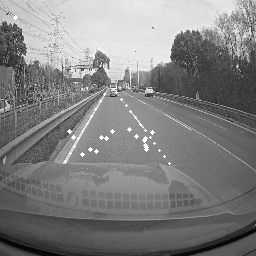

282/282 - 308s - loss: 0.2534 - polyline_width_loss: 0.1134 - polyline_height_loss: 0.1399 - polyline_width_mean_squared_error: 0.1304 - polyline_height_mean_squared_error: 0.1633 - val_loss: 0.5070 - val_polyline_width_loss: 0.1811 - val_polyline_height_loss: 0.3259 - val_polyline_width_mean_squared_error: 0.2398 - val_polyline_height_mean_squared_error: 0.6701 - lr: 0.0010 - 308s/epoch - 1s/step
Epoch 2/10
Epoch 1. Draw polylines on train generator...


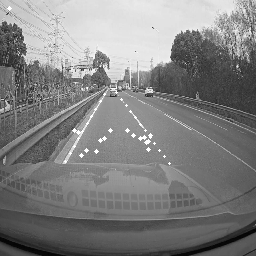

282/282 - 309s - loss: 0.2515 - polyline_width_loss: 0.1127 - polyline_height_loss: 0.1388 - polyline_width_mean_squared_error: 0.1338 - polyline_height_mean_squared_error: 0.1655 - val_loss: 0.6870 - val_polyline_width_loss: 0.1820 - val_polyline_height_loss: 0.5050 - val_polyline_width_mean_squared_error: 0.2406 - val_polyline_height_mean_squared_error: 3.1169 - lr: 0.0010 - 309s/epoch - 1s/step
Epoch 3/10


KeyboardInterrupt: ignored

In [44]:
history = model.fit(train_generator,
                    epochs=10,
                    verbose=2,
                    validation_data=validation_generator,
                    callbacks=[
                        tensorboard_callback,
                        early_stop_polyline_callback,
                        reduce_lr_callback_depends_on_polyline_1_loss,
                        reduce_lr_callback_depends_on_polyline_2_loss,
                        model_checkpoint_callback,
                        DrawPolylineOnEpochEnd(train_generator=train_generator, validation_generator=validation_generator,model=model)
                      ],
                    )

In [86]:
model.load_weights(checkpoint_filepath)

In [87]:
from google.colab import files

In [88]:
model_name_download = MODEL_NAME + '.h5'
model_name_download

'standart-output-polyline-256x256-shape.h5'

In [89]:
model.save(model_name_download)

In [ ]:
files.download(model_name_download)